# Notebook 024: Logistic Classifier Models using final predictor set

This notebook contains a baseline crime-type classifier model using an initial set of property-related predictors.

The response variable is:

       'crime-type'

Features used in this initial baseline model include:

       'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio',
       'residential-median-value', 'residential-gini-coef',
       'industrial-mix-ratio-3yr-cagr', 'commercial-mix-ratio-3yr-cagr',
       'owner-occupied-ratio-3yr-cagr', 'residential-median-value-3yr-cagr',
       'residential-gini-coef-3yr-cagr', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'night'

The baseline models tested are Multi-class Logistic Regression Models with and without regularization.

In [35]:
import urllib
import os
import operator
import pathlib
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Point

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LassoCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

%matplotlib inline

In [10]:
DATA_ROOT = '../data/'
FIGURES_ROOT = '../figures/model-logistic'
WRITEDIR_ROOT = '../models/logistic'

READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
SHAPEDIR_ROOT = os.path.join(DATA_ROOT, 'raw')

readfile_model_X = os.path.join(READDIR_ROOT, 'X_train.csv')
readfile_model_X_scaled = os.path.join(READDIR_ROOT, 'X_train_scaled.csv')
readfile_model_y = os.path.join(READDIR_ROOT, 'y_train.csv')
readfile_model_X_test = os.path.join(READDIR_ROOT, 'X_test.csv')
readfile_model_X_test_scaled = os.path.join(READDIR_ROOT, 'X_test_scaled.csv')
readfile_model_y_test = os.path.join(READDIR_ROOT, 'y_test.csv')
readfile_model_X_scaler = os.path.join(READDIR_ROOT, 'X_scaler.csv')

readfile_zipshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zipcodes/ZIP_Codes.shp')
readfile_cityshape = os.path.join(SHAPEDIR_ROOT, 'shapefile/city-boundary/City_of_Boston_Boundary.shp')
readfile_streetshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/street-segments/Boston_Street_Segments.shp')
readfile_tractshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/census-tracts/Census_2010_Tracts.shp')
readfile_hoodshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/boston-neighborhoods/Boston_Neighborhoods.shp')
readfile_zonesubshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/zoning-subdistricts/Zoning_Subdistricts.shp')
readfile_openshapes = os.path.join(SHAPEDIR_ROOT, 'shapefile/open-spaces/Open_Space.shp')

print(
    'readfile paths for datasets used in this notebook are:\n\t{}\n\t{}\n\t{}\n\t{}\n'.format(
        readfile_model_X, readfile_tractshapes, FIGURES_ROOT, WRITEDIR_ROOT
    )
)

readfile paths for datasets used in this notebook are:
	../data/processed/X_train.csv
	../data/raw/shapefile/census-tracts/Census_2010_Tracts.shp
	../figures/model-logistic
	../models/logistic



In [4]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(WRITEDIR_ROOT):
    os.mkdir(WRITEDIR_ROOT)

## Read labeled training and TEST data and subset predictors and response variable

In [100]:
# read in labeled model data
X_train_labels = pd.read_csv(readfile_model_X)
X_train_scaled_labels = pd.read_csv(readfile_model_X_scaled)
y_train_labels = pd.read_csv(readfile_model_y)

X_test_labels = pd.read_csv(readfile_model_X_test)
X_test_scaled_labels = pd.read_csv(readfile_model_X_test_scaled)
y_test_labels = pd.read_csv(readfile_model_y_test)

# read in scaled data scaling parameters to restore scaled values if needed
X_scaler = pd.read_csv(readfile_model_X_scaler)

In [101]:
# subset X and Y data to include only the columns used for model training
predictor_columns = list(X_train_labels.iloc[:,17:].columns)
response_column = ['crime-type']

X_train = X_train_labels[predictor_columns].copy()
X_train_scaled = X_train_scaled_labels[predictor_columns].copy()
y_train = y_train_labels[response_column].values.ravel()

X_test = X_test_labels[predictor_columns].copy()
X_test_scaled = X_test_scaled_labels[predictor_columns].copy()
y_test = y_test_labels[response_column].values.ravel()

In [102]:
# summarize dataframe info
print('Y TRAIN DATA WITH ADDITIONAL LABELS\n')
y_train_labels.info()
print('\n\nX TRAIN DATA WITH ADDITIONAL LABELS\n')
X_train_labels.info()
print('\n\nX TRAIN PREDICTORS (WITH LABEL COLUMNS EXCLUDED)\n')
print(predictor_columns)
print('\n\nTHE SHAPE OF THE X AND Y TRAIN FRAMES WITH PREDICTORS ONLY\n')
print(X_train.shape)
print(X_train_scaled.shape)
print(y_train.shape)
print('\n\nX SCALER DATA INFO\n')
X_scaler.info()
print(
    '\n\nTHE X SCALER DATA CONTAINS MEANS AND STDS FOR THE FOLLOWING STANDARDIZED '\
    '(i.e. SCALED) PREDICTORS\n\n{}'.format(X_scaler['scaled-feature'].values)
)

Y TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 4 columns):
crime-type             128352 non-null int64
crime-type-cat         128352 non-null object
OFFENSE_DESCRIPTION    128352 non-null object
INCIDENT_NUMBER        128352 non-null object
dtypes: int64(1), object(3)
memory usage: 3.9+ MB


X TRAIN DATA WITH ADDITIONAL LABELS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128352 entries, 0 to 128351
Data columns (total 60 columns):
date                                 128352 non-null object
year                                 128352 non-null int64
month                                128352 non-null int64
hour                                 128352 non-null int64
time                                 128352 non-null int64
ZIP5                                 128352 non-null int64
ZIP5_area                            128352 non-null float64
Name                                 128352 non-null o

In [103]:
# create lists of predictors based on numeric type for easier treatment of specific types
predictors_binary = [
    'night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',
    'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 
    'college-near', 'highschool-near'
]
predictors_nonbinary = [col for col in X_train.columns if col not in predictors_binary]
predictors_discrete = [
    'streetlights-night',
    'median-age',
]
predictors_continuous = [col for col in predictors_nonbinary if col not in predictors_discrete]

print(
    'Binary predictors in the X training data are:\n\n{}\n\n\n'\
    'Non-binary predictors are:\n\n{}\n\n\n'\
    'Of the non-binary, the following are discrete:\n\n{}\n\n\n'\
    'And these remaining are continuous:\n\n{}\n'.format(
        predictors_binary,
        predictors_nonbinary,
        predictors_discrete,
        predictors_continuous
    )
)

Binary predictors in the X training data are:

['night', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'college-near', 'highschool-near']


Non-binary predictors are:

['streetlights-night', 'lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-age', 'median-income', 'poverty-rate', 'less-than-high-school-perc', 'bachelor-degree-or-more-perc', 'enrolled-college-perc', 'commercial-mix-ratio', 'industrial-mix-ratio', 'owner-occupied-ratio', 'residential-median-value', 'residential-gini-coef', 'commercial-mix-ratio-3yr-cagr', 'industrial-mix-ratio-3yr-cagr', 'owner-occupied-ratio-3yr-cagr', 'residential-gini-coef-3yr-cagr', 'residential-median-value-3yr-cagr']


Of the non-binary, the following are discrete:

['streetlights-night', 'median-age']


And these remaining are continuous:

['lat', 'lon', 'tempavg', 'windavg', 'precip', 'snowfall', 'median-income', 'poverty-rate', 'less

## Inspect multi-collinearity of predictors

In [104]:
def sort_pairwise_correlation(X_train):
    """
    Calculates a correlation matrix of all input predictors and observations,
    via the X_train dataframe, then returns a sorted dataframe of all
    pairwise correlation values (duplicates and same-value pairings removed).
    
    The returned sorted correlation summary dataframe is sorted in descending
    order, from highest to lowest correlation pairings.
    """
    # calculate correlation among all predictors
    correlation_matrix_df = X_train.corr()
    correlation_abs_matrix_df = X_train.corr().abs()

    # identify variables most heavily correlated in descending order
    # and remove pairwise groupings of the same predictors
    corr_unstack = correlation_abs_matrix_df.unstack()
    corr_sorted = corr_unstack.sort_values(ascending=False)
    corr_sorted = corr_sorted[corr_sorted < 1][::2]
    
    return corr_sorted


In [105]:
#############################################
## Calculate and report on pairwise correlations
#############################################

# generate sorted correlation dataframe
corr_df = sort_pairwise_correlation(X_train)

# set corr threshold for reporting
corr_thresh = 0.50

print(
    '\nThe most strongly correlated predictors (corr > {0:.2f}) in our baseline model '\
    'predictor set and their corresponding correlation values are:\n\n{1}\n'.format(
        corr_thresh,
        corr_df[corr_df > corr_thresh],
    )
)


The most strongly correlated predictors (corr > 0.50) in our baseline model predictor set and their corresponding correlation values are:

poverty-rate                  median-income                   0.832140
bachelor-degree-or-more-perc  less-than-high-school-perc      0.829621
night                         streetlights-night              0.814221
enrolled-college-perc         bachelor-degree-or-more-perc    0.775921
owner-occupied-ratio          enrolled-college-perc           0.735861
median-age                    owner-occupied-ratio            0.726905
residential-gini-coef         residential-median-value        0.719481
median-income                 less-than-high-school-perc      0.718383
bachelor-degree-or-more-perc  median-income                   0.714370
                              residential-gini-coef           0.672335
college-near                  enrolled-college-perc           0.670402
poverty-rate                  median-age                      0.668691
enrolled

## Create value count summary tables by crime-type for later reference

In [131]:
agg_dict = {'INCIDENT_NUMBER': 'count'}

crime_types_train = y_train_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_train['proportion'] = crime_types_train / crime_types_train.sum()

crime_types_test = y_test_labels.groupby(
    ['crime-type', 'crime-type-cat']
).agg(agg_dict).rename(columns=agg_dict)

crime_types_test['proportion'] = crime_types_test / crime_types_test.sum()

In [135]:
print(
    'The number of observed crime type classes in both the training and test set are:\n\n'\
    'TRAINING\n{}\n\n\nTEST\n{}\n'.format(
        crime_types_train,
        crime_types_test
    )
)

The number of observed crime type classes in both the training and test set are:

TRAINING
                                   count  proportion
crime-type crime-type-cat                           
0          other                    6321    0.049247
1          burglary                 5664    0.044129
2          drugs-substances        13082    0.101923
3          fraud                    9587    0.074693
4          harassment-disturbance  20767    0.161797
5          robbery                  3423    0.026669
6          theft                   34555    0.269221
7          vandalism-property      13710    0.106816
8          violence-aggression     21243    0.165506


TEST
                                   count  proportion
crime-type crime-type-cat                           
0          other                    1580    0.049240
1          burglary                 1416    0.044129
2          drugs-substances         3271    0.101938
3          fraud                    2397    0.074701
4

## MODEL 1: Fit a multi-class multiple Logistic regression model first to ONLY the latitude and longitude predictors

In [108]:
def summarize_predictions(predictions_train, predictions_test):
    """
    """
    pred_counts_train = np.array(np.unique(predictions_train, return_counts=True)).T
    pred_counts_test = np.array(np.unique(predictions_test, return_counts=True)).T
    
    pred_counts_train = np.hstack(
        [pred_counts_train, pred_counts_train[:,1].reshape(-1,1)/np.sum(pred_counts_train[:,1])]
    )
    pred_counts_test = np.hstack(
        [pred_counts_test, pred_counts_test[:,1].reshape(-1,1)/np.sum(pred_counts_test[:,1])]
    )

    print(
        'The number of classes predicted by class for both the training and test sets are:\n'\
    )

    print('TRAINING')
    print('Class\tProportion\tPredictions')
    for i in pred_counts_train:
        print(
            '{}\t{:.4f}\t\t{:,}'.format(int(i[0]), i[2], int(i[1]))
        )
    
    print('\nTEST')
    print('Class\tProportion\tPredictions')
    for i in pred_counts_test:
        print(
            '{}\t{:.4f}\t\t{:,}'.format(int(i[0]), i[2], int(i[1]))
        )

In [106]:
%%time

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogLocs = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[['lat', 'lon']], y_train)

mnloglocs_score_train = MNLogLocs.score(X_train[['lat', 'lon']], y_train)
mnloglocs_score_test = MNLogLocs.score(X_test[['lat', 'lon']], y_test)
mnloglocs_pred_train = MNLogLocs.predict(X_train[['lat', 'lon']])
mnloglocs_pred_test = MNLogLocs.predict(X_test[['lat', 'lon']])

print(MNLogLocs)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnloglocs_score_train,
        mnloglocs_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Multinomial model using only latitude and longitude as predictors are:

Training	0.2706
TEST		0.2733

CPU times: user 4.03 s, sys: 51.7 ms, total: 4.08 s
Wall time: 1.07 s


In [109]:
summarize_predictions(mnloglocs_pred_train, mnloglocs_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
4	0.1203		15,446
6	0.8797		112,906

TEST
Class	Proportion	Predictions
4	0.1228		3,939
6	0.8772		28,149


## MODEL 2: Fit a multi-class multiple Logistic regression model first to the SCALED data and inspect results

In [140]:
%%time

# redo baseline predictors
cols = [
    'lat',
    'lon',
    'commercial-mix-ratio',
    'industrial-mix-ratio',
    'owner-occupied-ratio',
    'residential-median-value',
    'residential-gini-coef',
    'commercial-mix-ratio-3yr-cagr',
    'industrial-mix-ratio-3yr-cagr',
    'owner-occupied-ratio-3yr-cagr',
    'residential-gini-coef-3yr-cagr',
    'residential-median-value-3yr-cagr'
]

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogBase = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[cols], y_train)

mnlogbase_score_train = MNLogBase.score(X_train[cols], y_train)
mnlogbase_score_test = MNLogBase.score(X_test[cols], y_test)
mnlogbase_pred_train = MNLogBase.predict(X_train[cols])
mnlogbase_pred_test = MNLogBase.predict(X_test[cols])

print(MNLogBase)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogbase_score_train,
        mnlogbase_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2692
TEST		0.2692

CPU times: user 4.8 s, sys: 83.8 ms, total: 4.88 s
Wall time: 1.61 s


In [141]:
summarize_predictions(mnlogbase_pred_train, mnlogbase_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
6	1.0000		128,352

TEST
Class	Proportion	Predictions
6	1.0000		32,088


In [142]:
%%time

# redo baseline predictors
cols = list(X_train.columns)

solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
multi_class='multinomial'

MNLogAll = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20
).fit(X_train[cols], y_train)

mnlogall_score_train = MNLogAll.score(X_train[cols], y_train)
mnlogall_score_test = MNLogAll.score(X_test[cols], y_test)
mnlogall_pred_train = MNLogAll.predict(X_train[cols])
mnlogall_pred_test = MNLogAll.predict(X_test[cols])

print(MNLogAll)
print()
print(
    'The resulting training and test accuracy scores are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        mnlogall_score_train,
        mnlogall_score_test
    )
)

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores are:

Training	0.2692
TEST		0.2692

CPU times: user 18.5 s, sys: 232 ms, total: 18.7 s
Wall time: 5.09 s


In [143]:
summarize_predictions(mnlogall_pred_train, mnlogall_pred_test)

The number of classes predicted by class for both the training and test sets are:

TRAINING
Class	Proportion	Predictions
6	1.0000		128,352

TEST
Class	Proportion	Predictions
6	1.0000		32,088


## MODEL 3: Fit a multi-class multiple Logistic regression model with LASSO (L1) regularization to the SCALED data and inspect results

In [24]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='ovr'

LassoScaledOVRLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledOVRLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized OVR model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledOVRLogModel.score(X_train_scaled, y_train),
        LassoScaledOVRLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized OVR model using the scaled data are:

Training	0.2732
TEST		0.2726

CPU times: user 31.6 s, sys: 23.9 ms, total: 31.6 s
Wall time: 31 s


In [25]:
%%time

solver = 'saga'
C = 1
max_iter = 10000
penalty = 'l1'

# fit OVR model without L1 regularization
multi_class='multinomial'

LassoScaledMNLogModel = LogisticRegression(
    C=C,
    solver=solver,
    max_iter=max_iter,
    multi_class=multi_class,
    random_state=20,
    penalty=penalty
).fit(X_train_scaled, y_train)

print(LassoScaledMNLogModel)
print()
print(
    'The resulting training and test accuracy scores for the Lasso regularized Multinomial model '\
    'using the scaled data are:\n\n'\
    'Training\t{0:.4f}\nTEST\t\t{1:.4f}\n'.format(
        LassoScaledMNLogModel.score(X_train_scaled, y_train),
        LassoScaledMNLogModel.score(X_test_scaled, y_test)
    )
)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=20, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

The resulting training and test accuracy scores for the Lasso regularized Multinomial model using the scaled data are:

Training	0.2733
TEST		0.2730

CPU times: user 1min 14s, sys: 23.9 ms, total: 1min 14s
Wall time: 1min 13s


## Plot coefficients for Lasso Multinomial Logistic Regression

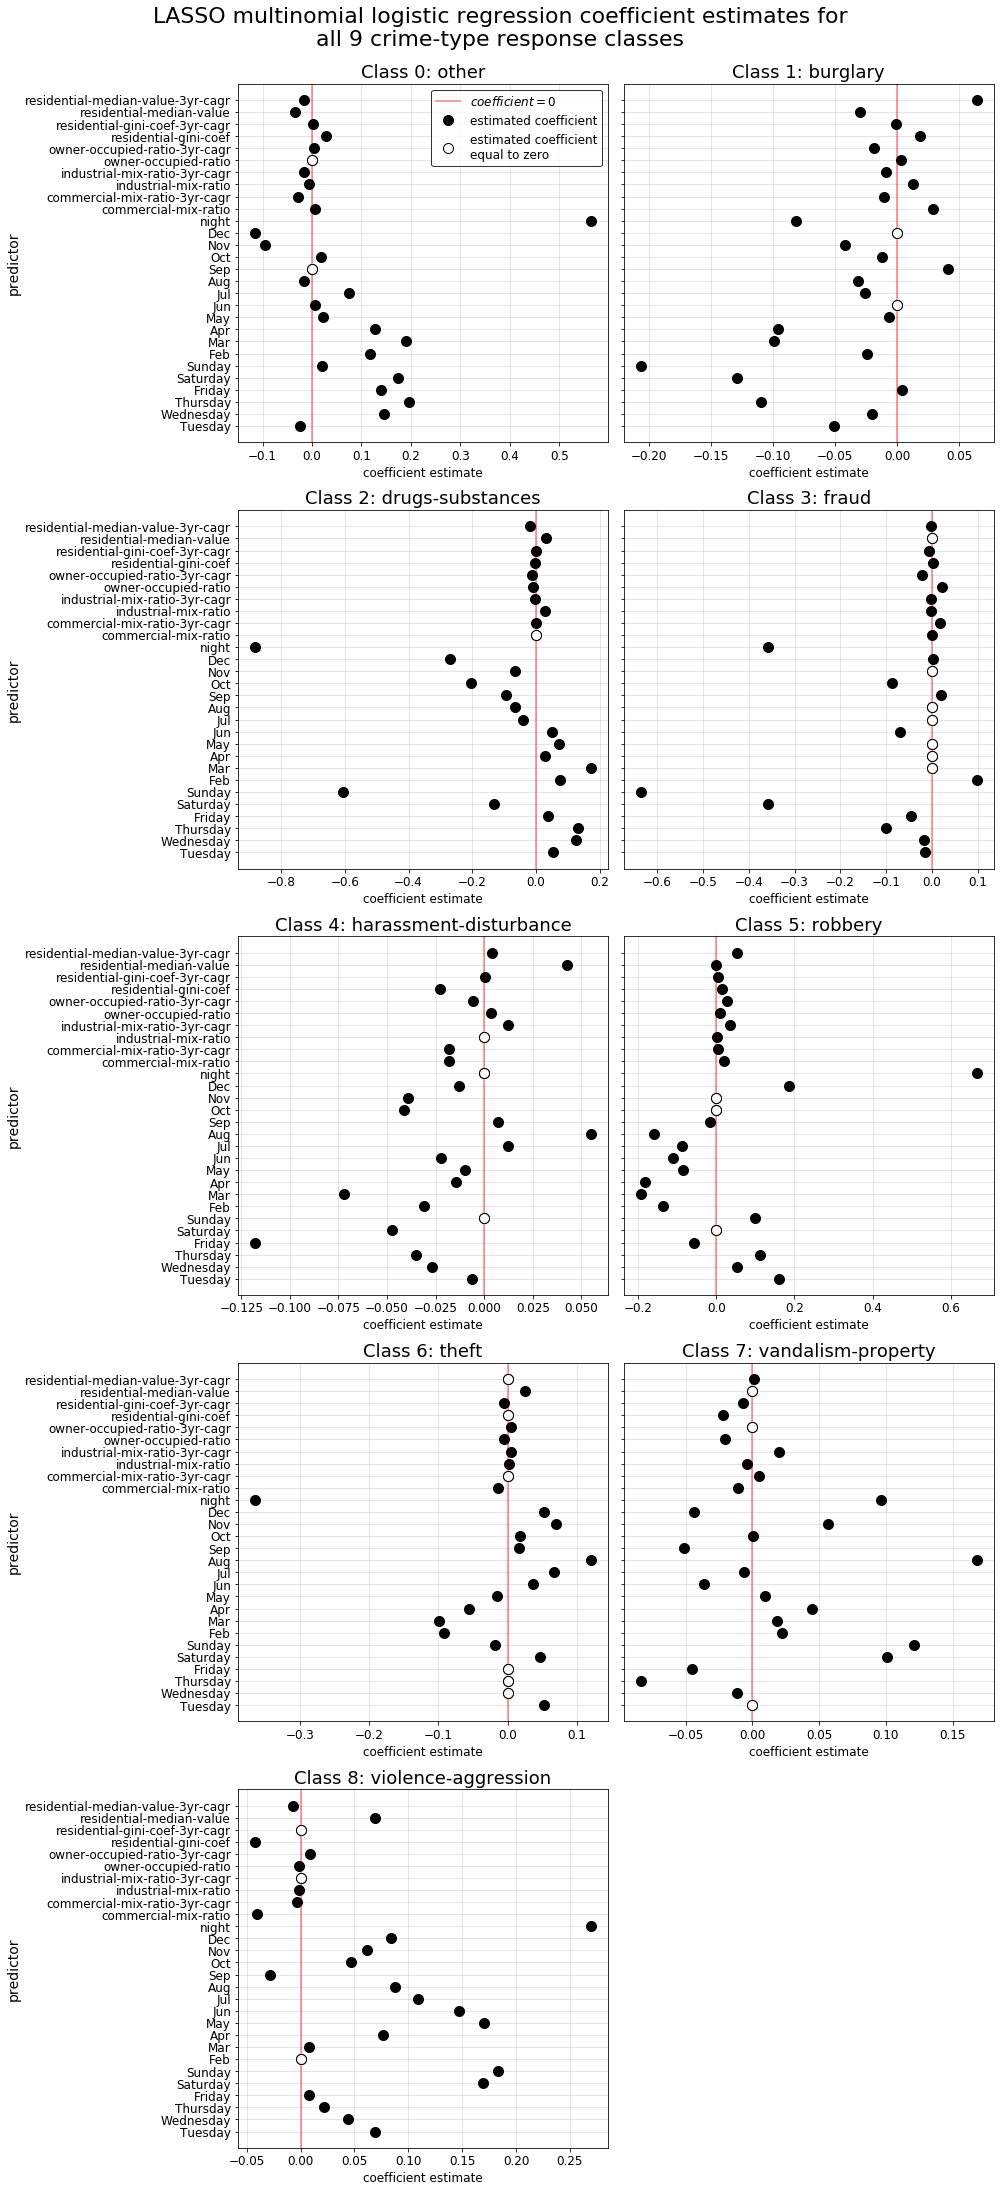

In [26]:
#plot comparison of model coefficients
savefig = True

# set values required for plotting
lasso_coefs = LassoScaledMNLogModel.coef_
predictor_labels = X_train_scaled.columns
crime_type_list = list(crime_type_dict.keys())

# make plot
fig, axes = plt.subplots(5, 2, sharey=True, figsize=(14,32))

plt.suptitle(
    'LASSO multinomial logistic regression coefficient estimates for\nall '\
    '{0} crime-type response classes'\
    ''.format(len(crime_type_list)),
    fontsize=22,
)

for i, ax in enumerate(axes.flat):
    if i < 9:
        ax.set_title('Class {0}: {1}'.format(i, crime_type_list[i]), fontsize=18)
    
        ax.axvline(0, c='r', alpha=0.5, label='$coefficient=0$')

        ax.plot(
            lasso_coefs[i],
            predictor_labels,
            lw = 0,
            marker='o',
            alpha=1,
            ms=10,
            color='k',
            label='estimated coefficient'
        )

        ax.plot(
            lasso_coefs[i][lasso_coefs[i]==0],
            predictor_labels[lasso_coefs[i]==0],
            lw = 0,
            marker='o',
            alpha=1,
            ms=10,
            color='white',
            markeredgecolor='k',
            label='estimated coefficient\nequal to zero'
        )

        ax.set_xlabel('coefficient estimate', fontsize=12)
        ax.grid(':', alpha=0.4)
        ax.tick_params('both', labelsize=12)

    if i % 2 == 0:
        ax.set_ylabel('predictor', fontsize=14)
    if i == 0:
        ax.legend(fontsize=12, markerscale=1, edgecolor='k')
        
    if i == 9:
        # hide all markings for final axis    
        for pos in ['right','top','bottom','left']:
            ax.spines[pos].set_visible(False)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)

plt.xticks(fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])
if savefig:
    plt.savefig(os.path.join(FIGURES_ROOT, 'base-model-lasso-coefficient-estimates.png'))
plt.show();